# Importing modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix, classification_report

# Import Data Frame

In [2]:
columnsWine = ["WineID", "Alcohol", "MalicAcid", "Ash", "AlcalinityOfAsh", "Magnesium", "TotalPhenols", 
               "Flavanoids", "NonflavanoidPhenols","Proanthocyanins", "ColorIntensity", "Hue", "OD280/OD315", "Proline"]

df = pd.read_csv(r"C:\Users\Cristofer Becerra S\Documents\Tec de Monterrey\7mo Semestre\Datasets\wine.data", 
                 names = columnsWine)

In [3]:
df.head()

,WineID,Alcohol,MalicAcid,Ash,AlcalinityOfAsh,Magnesium,TotalPhenols,Flavanoids,NonflavanoidPhenols,Proanthocyanins,ColorIntensity,Hue,OD280/OD315,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


# Preprocessing data for the Neural Network

We wish to standardize the input of the neural network to align with the Multi-layer Perceptron Classifier's output. We apply a Min-Max scaling to our feature data and a Label Encoder to our wine categories.

In [4]:
le = LabelEncoder()
# scaler = StandardScaler()
minmax = MinMaxScaler()

In [5]:
x = minmax.fit_transform(df.drop(columns = "WineID"))
y = le.fit_transform(df.WineID)

# Train-validate-test split

We divide the dataset into 3 subsets: **train** (56%), **validate** (24%), and **test** (20%). We will also work with the same random state (0) for all Sklearn's functions for reproducibility.

In [6]:
rs, rsData = 0, 0
x1, x_test, y1, y_test = train_test_split(x, y, train_size = 0.8, random_state = rsData)
x_train, x_validate, y_train, y_validate = train_test_split(x1, y1, train_size = 0.7, random_state = rsData)

# Neural Network Comparison

We will compare the performance of two neural networks with a fixed set of epochs (50). The goal is to obtain the best score without overfitting witht the given restraint (epochs).

In [7]:
epochs = 50

## Simple NN

First we build a simple neural network. Let a simple neural network have 1 hidden layer with 2 neurons, optimized by *optimized* Stochastic Gradient Descent (Adaptive Moment Estimation, Adam) using a ReLu activation function, an adaptive learning rate starting at 0.01.

In [8]:
simpleNN = MLPClassifier(random_state = rs, hidden_layer_sizes = (2,), learning_rate = "adaptive", 
                         learning_rate_init = 0.01, max_iter = epochs)

We can train and overview its performance by a simple mean accuracy score for both training and test datasets.

In [9]:
simpleNN.fit(x_train, y_train)
print("Training score: ", round(simpleNN.score(x_train, y_train), 4))
print("Validate score: ", round(simpleNN.score(x_validate, y_validate), 4))
print("Test score: ", round(simpleNN.score(x_test, y_test), 4))

Training score:  0.7778
Validate score:  0.814
Test score:  0.8056


C:\Users\Cristofer Becerra S\pyproject\Jupyter\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


It appears that the optimization does not converge with the iterations constraint, but it yields decent results without overfitting. Given more iterations the loss function will indeed minimize and yield better scores, and hopefully it doesn't fall into overfitting territory.

In [10]:
del simpleNN

## Optimized NN

Now, we can perform a *rudimentary* optimization of the parameters of the network. This can be done using Scikit-learn's GridSearch algorithm for exhaustive search of the best model using different combinations passed to it.

### Simple Grid Search Optimization

In [11]:
from sklearn.model_selection import GridSearchCV

Since Adam is an optimizer of the simple SGD, we can reduce the combinations by only employing this version of SGD. Also, given the functionality of Scikit-learn and the fact that adaptive learning rate is more practical than constant (generally yielding better results for rudimentary implementations such as this one), we will also reduce the parameters by only using adaptive learning rates. We will focus the grid search on the structure of the layers, the learning rate and the regularization parameter.

In [12]:
hyperparameters = {'activation': ['relu'], 
                   'hidden_layer_sizes': [(2,), (4,), (8,), (16,), (64,), 
                                          (2,2,), (4,2), (2,4), (8,2), (2,8), (8,4), (4,8),
                                         (2,2,2), (4,2,2), (2,4,2), (4,2,4), (4,8,2), (4,8,4), (8,8,8)],
                   'alpha': [0.0001, 0.0005, 0.001, 0.01],
                   'learning_rate_init': [0.001, 0.01, 0.1],
                   'learning_rate': ['adaptive'],
                   'solver': ['adam']}

**DANGER**: this is an intensive CPU cell. Do not run this cell if your computer isn't very capable or if you're running it in Google Colab (it'll truly take forever). You've been warned.

In [13]:
nn = MLPClassifier(random_state = rs, max_iter = epochs)

hps = GridSearchCV(nn, hyperparameters, n_jobs = -1, cv = 5) # hyper-parameter search

hps.fit(x_train, y_train);

bestH = hps.best_params_

SearchResults = pd.DataFrame(hps.cv_results_)
SearchResults = SearchResults.sort_values("rank_test_score", ascending = True)
SearchResults.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_learning_rate_init,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
170,0.187684,0.034293,0.001395,0.001857,relu,0.001,"(8, 8, 8)",adaptive,0.1,adam,"{'activation': 'relu', 'alpha': 0.001, 'hidden...",0.95,1.0,1.00,0.95,1.0,0.98,0.024495,1
113,0.115902,0.008395,0.001432,0.001070,relu,0.0005,"(8, 8, 8)",adaptive,0.1,adam,"{'activation': 'relu', 'alpha': 0.0005, 'hidde...",0.95,1.0,1.00,0.90,1.0,0.97,0.040000,2
65,0.061001,0.002577,0.001225,0.001631,relu,0.0005,"(8,)",adaptive,0.1,adam,"{'activation': 'relu', 'alpha': 0.0005, 'hidde...",0.95,1.0,0.95,0.95,1.0,0.97,0.024495,2
68,0.062889,0.005991,0.000942,0.001162,relu,0.0005,"(16,)",adaptive,0.1,adam,"{'activation': 'relu', 'alpha': 0.0005, 'hidde...",0.95,1.0,0.95,0.95,1.0,0.97,0.024495,2
70,0.076852,0.004012,0.002548,0.002399,relu,0.0005,"(64,)",adaptive,0.01,adam,"{'activation': 'relu', 'alpha': 0.0005, 'hidde...",0.95,1.0,0.95,0.95,1.0,0.97,0.024495,2


## Performance Comparison

Once we have obtained our "optimized" parameters, we proceed to define them in order to compare their performance.

In [14]:
simpleNN = MLPClassifier(random_state = rs, hidden_layer_sizes = (2,), learning_rate = "adaptive", 
                         learning_rate_init = 0.01, max_iter = epochs)

# Best model so far - 1.0 train, validate, test; convergence in 110 iterations
# optimizedNN = MLPClassifier(random_state = rs, hidden_layer_sizes = (8,8,16), learning_rate = "adaptive", 
#                             alpha = 0.01, learning_rate_init = 0.01, max_iter = 110)

optimizedNN = MLPClassifier(random_state = rs, hidden_layer_sizes = (8,8,8), learning_rate = "adaptive", 
                            alpha = 0.001, learning_rate_init = 0.01, max_iter = epochs)

We run a partial fit with the set number of epochs and storing their respective scores each iteration.

In [15]:
simpleTrainScore, simpleValidateScore, optimizedTrainScore, optimizedValidateScore = [], [], [], []
simpleTestScore, optimizedTestScore = [], []

for i in range(0, epochs):
    
    simpleNN.partial_fit(x_train, y_train, np.unique(y_train))
    
    simpleTrainScore.append(simpleNN.score(x_train, y_train))
    simpleValidateScore.append(simpleNN.score(x_validate, y_validate))
    simpleTestScore.append(simpleNN.score(x_test, y_test))
    
    optimizedNN.partial_fit(x_train, y_train, np.unique(y_train))
    
    optimizedTrainScore.append(optimizedNN.score(x_train, y_train))
    optimizedValidateScore.append(optimizedNN.score(x_validate, y_validate))
    optimizedTestScore.append(optimizedNN.score(x_test, y_test))

Peeking into the overall performance of our "optimized" NN:

In [16]:
print("Training score: ", optimizedNN.score(x_train, y_train))
print("Validate score: ", optimizedNN.score(x_validate, y_validate))
print("Testing score: ", optimizedNN.score(x_test, y_test))

Training score:  0.98989898989899
Validate score:  1.0
Testing score:  1.0


We can see that the NN performs extremely well in comparison with the simple NN, and is also not in overfitting territory; on the contrary, the NN performs better in the validate and test sets.

## Accuracy & Loss

Plotting the evolution of the accuracy on all sets and the loss function

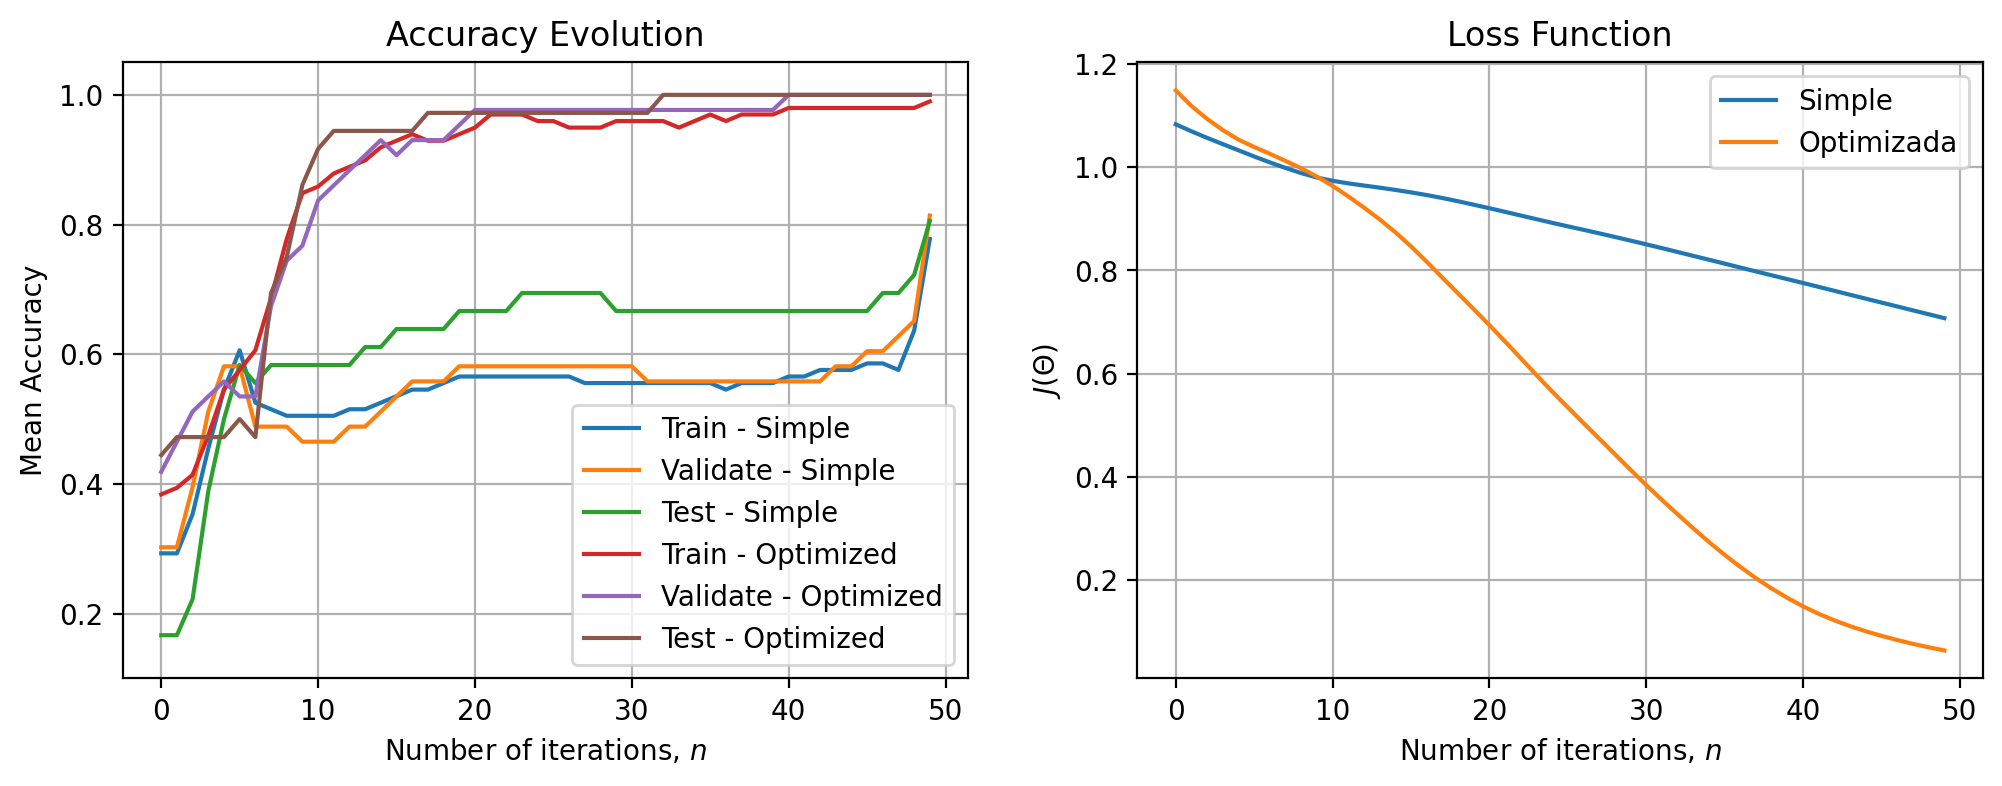

In [17]:
fig, axes = plt.subplots(1,2, figsize = (12,4))

axes[0].plot(simpleTrainScore, label = "Train - Simple ")
axes[0].plot(simpleValidateScore, label = "Validate - Simple")
axes[0].plot(simpleTestScore, label = "Test - Simple")

axes[0].plot(optimizedTrainScore, label = "Train - Optimized ")
axes[0].plot(optimizedValidateScore, label = "Validate - Optimized")
axes[0].plot(optimizedTestScore, label = "Test - Optimized")

axes[0].set_title("Accuracy Evolution")
axes[0].set_xlabel(r"Number of iterations, $n$")
axes[0].set_ylabel("Mean Accuracy")
axes[0].set_ylim([0.1, 1.05])
#axes[0].set_xlim([20, 80])
axes[0].grid(True)
axes[0].legend()

axes[1].plot(simpleNN.loss_curve_, label = "Simple")
axes[1].plot(optimizedNN.loss_curve_, label = "Optimizada")
axes[1].set_title("Loss Function")
axes[1].set_xlabel(r"Number of iterations, $n$")
axes[1].set_ylabel(r"$J(\Theta)$")
axes[1].legend()
axes[1].grid(True)

plt.show()

## Classification Metrics

We can also inspect the metrics of classification with a prediction on the subsets:

### Train

In [18]:
print(classification_report(y_train, optimizedNN.predict(x_train), target_names=["Wine A", "Wine B", "Wine C"]))

              precision    recall  f1-score   support

      Wine A       1.00      0.97      0.98        33
      Wine B       0.97      1.00      0.99        37
      Wine C       1.00      1.00      1.00        29

    accuracy                           0.99        99
   macro avg       0.99      0.99      0.99        99
weighted avg       0.99      0.99      0.99        99



### Validate

In [19]:
print(classification_report(y_validate, optimizedNN.predict(x_validate), target_names=["Wine A", "Wine B", "Wine C"]))

              precision    recall  f1-score   support

      Wine A       1.00      1.00      1.00        12
      Wine B       1.00      1.00      1.00        18
      Wine C       1.00      1.00      1.00        13

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43



### Test

In [20]:
print(classification_report(y_test, optimizedNN.predict(x_test), target_names=["Wine A", "Wine B", "Wine C"]))

              precision    recall  f1-score   support

      Wine A       1.00      1.00      1.00        14
      Wine B       1.00      1.00      1.00        16
      Wine C       1.00      1.00      1.00         6

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



## Confusion Matrices

Plotting the confusion matrices for both neural networks in the 3 subsets

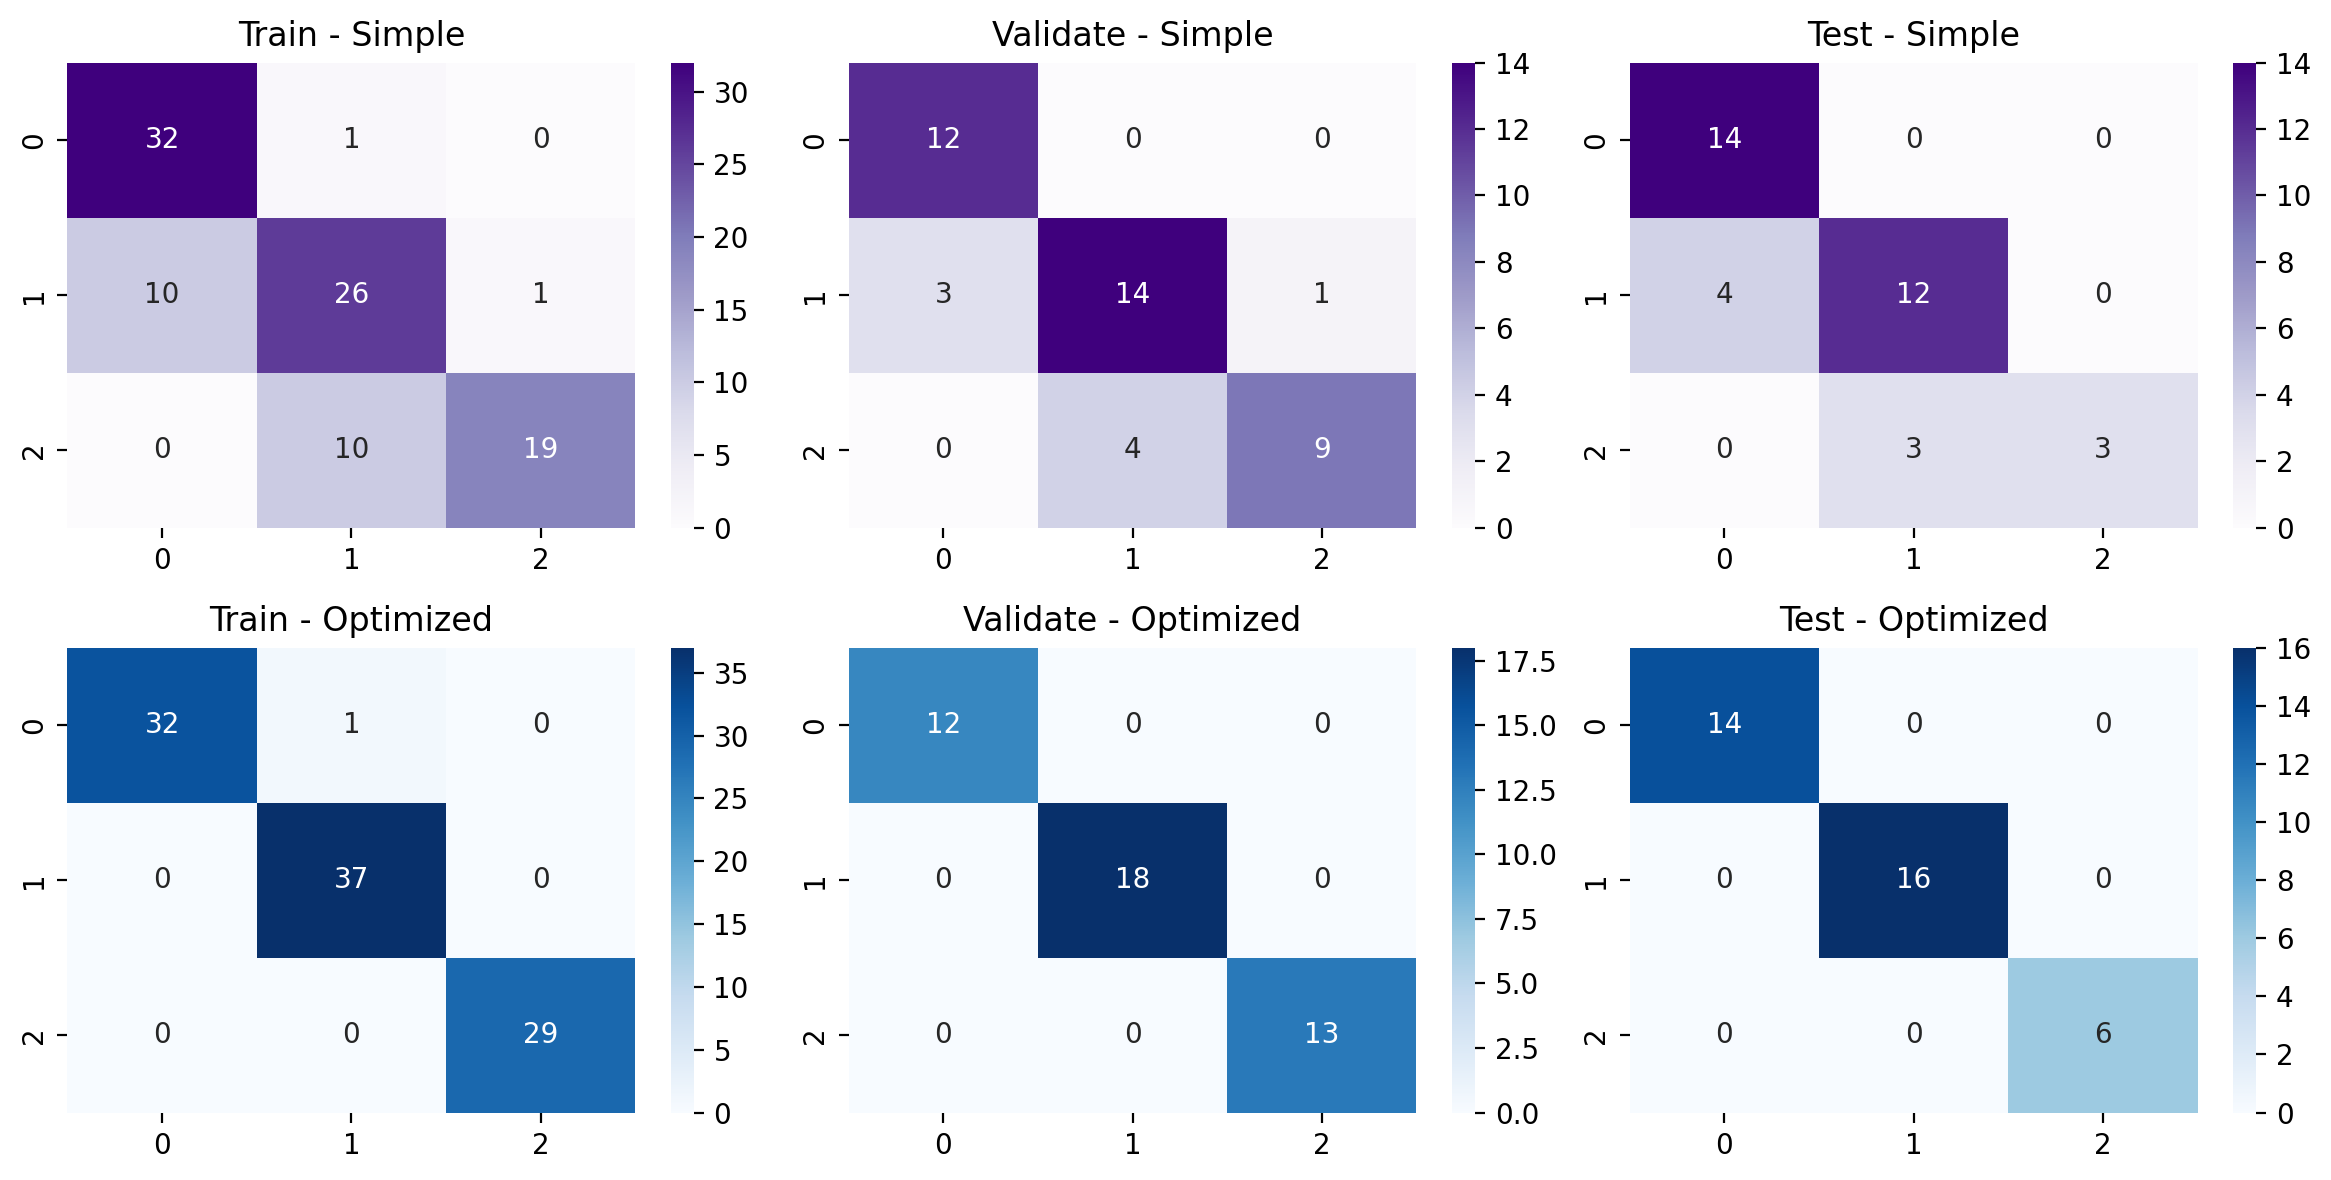

In [21]:
fig, axes = plt.subplots(2, 3, figsize = (12, 6))

sns.heatmap(confusion_matrix(y_train, simpleNN.predict(x_train)), annot = True, cmap = "Purples", ax = axes[0,0])
axes[0,0].set_title("Train - Simple")

sns.heatmap(confusion_matrix(y_validate, simpleNN.predict(x_validate)), annot = True, cmap = "Purples", ax = axes[0,1])
axes[0,1].set_title("Validate - Simple")

sns.heatmap(confusion_matrix(y_test, simpleNN.predict(x_test)), annot = True, cmap = "Purples", ax = axes[0,2])
axes[0,2].set_title("Test - Simple")

sns.heatmap(confusion_matrix(y_train, optimizedNN.predict(x_train)), annot = True, cmap = "Blues", ax = axes[1,0])
axes[1,0].set_title("Train - Optimized")

sns.heatmap(confusion_matrix(y_validate, optimizedNN.predict(x_validate)), annot = True, cmap = "Blues", ax = axes[1,1])
axes[1,1].set_title("Validate - Optimized")

sns.heatmap(confusion_matrix(y_test, optimizedNN.predict(x_test)), annot = True, cmap = "Blues", ax = axes[1,2])
axes[1,2].set_title("Test - Optimized")

plt.tight_layout()
plt.show()

## Performance as a function of Train-Test split

We can inspect the beahavior of our "optimized" NN as a train-test split changes proportions.

In [ ]:
train_score, test_score = [], []

PS = np.linspace(0.01, 0.99, epochs)

for ps in PS:
    
    x1, x_test, y1, y_test = train_test_split(x, y, train_size = ps, random_state = rsData)
    
    optimizedNN.fit(x_train, y_train);
    
    train_score.append(optimizedNN.score(x_train, y_train))
    test_score.append(optimizedNN.score(x_test, y_test))

In [23]:
print("Training score: ", np.array(train_score).mean())
print("Testing score: ", np.array(test_score).mean())

Training score:  0.98989898989899
Testing score:  0.9994098129366435


The mean score for both subsets suggests that the NN is very stable with different proportions of training and testing data. We can plot this variation as a function of the split percentage.

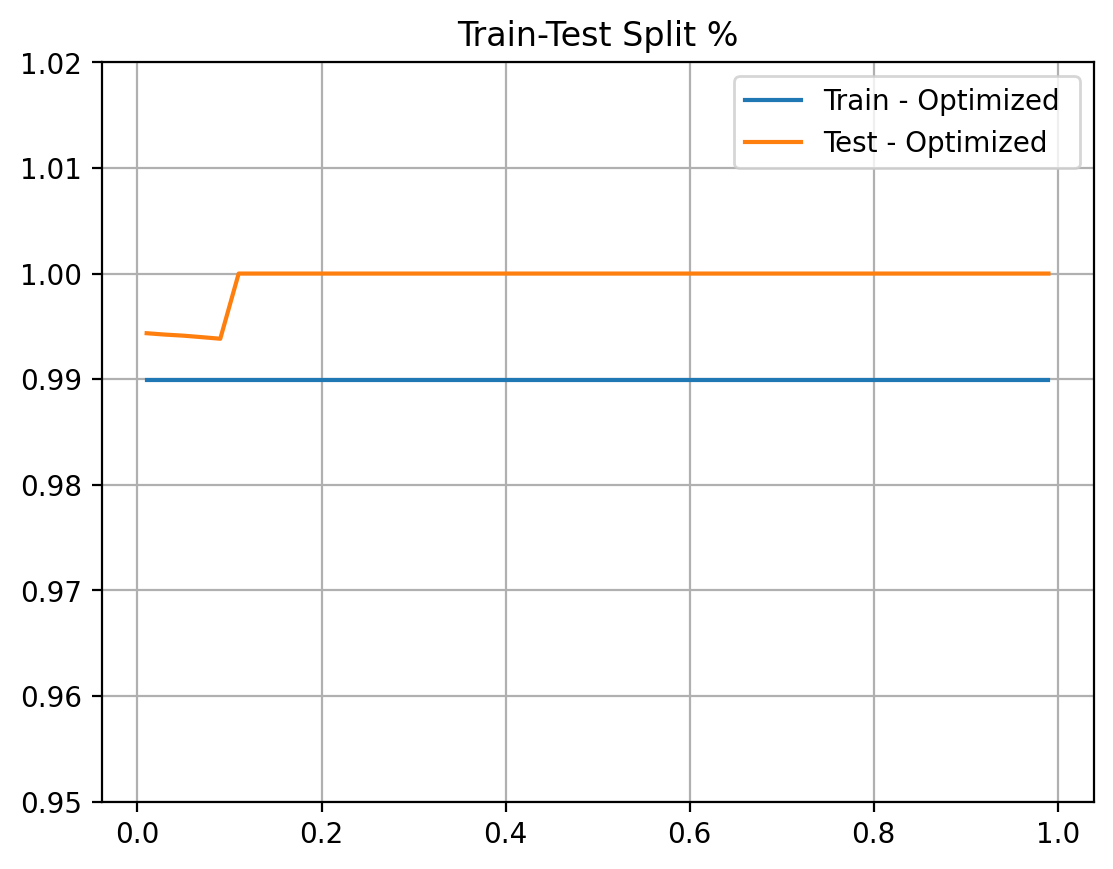

In [24]:
plt.plot(PS, train_score, label = "Train - Optimized ")
plt.plot(PS, test_score, label = "Test - Optimized")
plt.title("Train-Test Split %")
plt.ylim([0.95, 1.02])
plt.grid(True)
plt.legend()
plt.show()

## Performance as a function of Random State

Another important factor that can impact performance is the random state of the data split. We can test this in a similar fashion as the last evolution (train-test split)

In [ ]:
train_score_rs, test_score_rs = [], []

for i in range(epochs):
    
    x1, x_test, y1, y_test = train_test_split(x, y, train_size = 0.7, random_state = i)
    
    optimizedNN.fit(x_train, y_train);
    
    train_score_rs.append(optimizedNN.score(x_train, y_train))
    test_score_rs.append(optimizedNN.score(x_test, y_test))

In [26]:
print("Training score: ", np.array(train_score_rs).mean())
print("Testing score: ", np.array(test_score_rs).mean())

Training score:  0.98989898989899
Testing score:  0.9944444444444442


Once again, the NN performs extremely well in a very stable manner. We can also plot the evolution

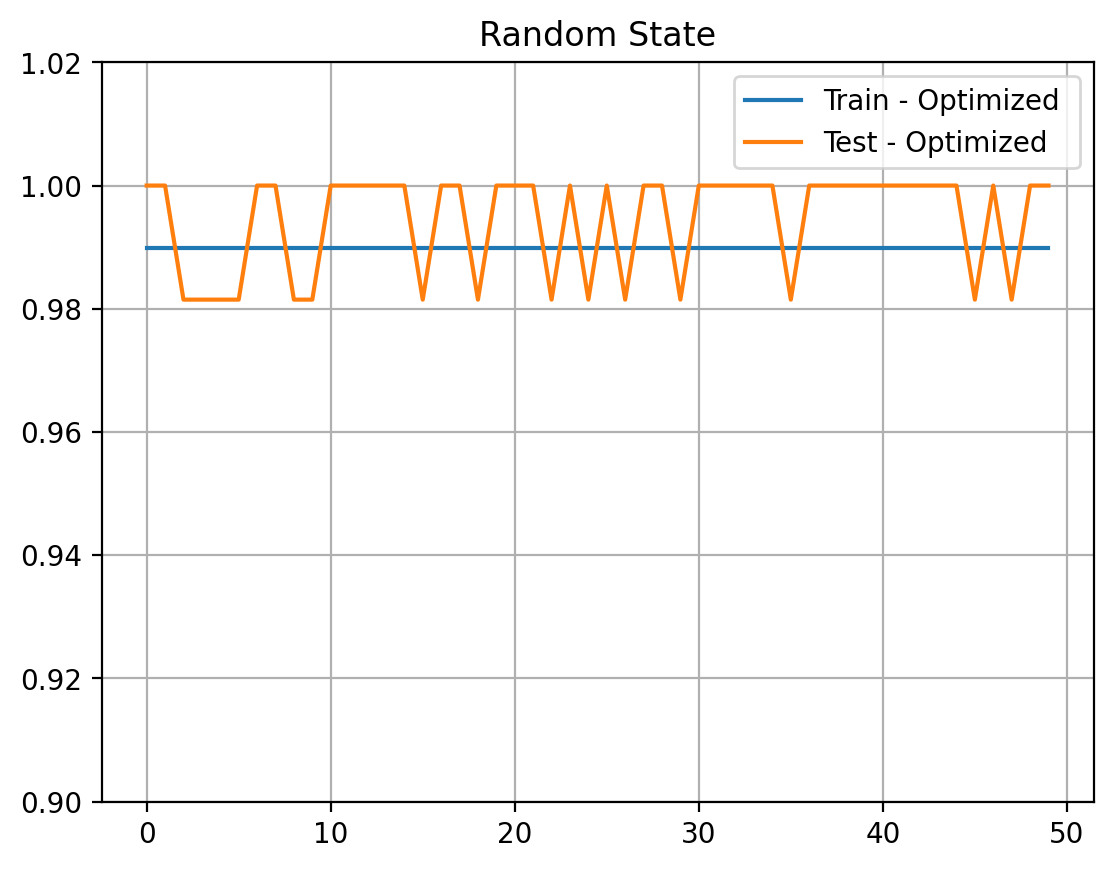

In [27]:
plt.plot(train_score_rs, label = "Train - Optimized ")
plt.plot(test_score_rs, label = "Test - Optimized")
plt.title("Random State")
plt.ylim([0.9, 1.02])
plt.grid(True)
plt.legend()
plt.show()

In this case we can see that testing performance oscillates between 0.98 and 1. This indicates that our NN is sensible to overfitting with different random samples of the data. This makes sense since the optimization with grid search was performed with a fixed random state of data.

# Model Predictions

Finally, we can make specific predictions with our model. We extract the first five observations of the test dataset and make a Pandas DataFrame for visualization purposes.

In [28]:
x_predictions = pd.DataFrame(x_test[0:5], columns = columnsWine[1:])
x_predictions.head()

,Alcohol,MalicAcid,Ash,AlcalinityOfAsh,Magnesium,TotalPhenols,Flavanoids,NonflavanoidPhenols,Proanthocyanins,ColorIntensity,Hue,OD280/OD315,Proline
0,0.531579,0.616601,0.513369,0.613402,0.163043,0.231034,0.263713,0.905660,0.381703,0.300341,0.292683,0.271062,0.169044
1,0.365789,0.357708,0.486631,0.587629,0.217391,0.241379,0.316456,1.000000,0.318612,0.121160,0.308943,0.743590,0.026391
2,0.500000,0.604743,0.689840,0.412371,0.347826,0.493103,0.436709,0.226415,0.495268,0.274744,0.447154,0.824176,0.350927
3,0.160526,0.260870,0.588235,0.567010,0.152174,0.334483,0.284810,0.660377,0.296530,0.129693,0.422764,0.542125,0.286733
4,0.444737,0.199605,0.491979,0.613402,0.152174,0.137931,0.299578,0.660377,0.384858,0.172355,0.325203,0.421245,0.149786


Then we can create another Data Frame to store the real category of wine, and then add the column of the predictions yielded by our optimized neural network.

In [29]:
y_prediction = pd.DataFrame(y_test[0:5], columns = ["Real"])
y_prediction["Prediction"] = optimizedNN.predict(x_test[0:5])
y_prediction

,Real,Prediction
0,1,1
1,1,1
2,0,0
3,1,1
4,1,1


We get an expected result: our neural network aced the five predictions.